## Colab tools
Буду запускать на Колабе, так как у меня не достаточно мощностей на компьютере. :)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [3]:
!tar -xvf /content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition/data/casia_faces.tar.gz -C data

Streaming output truncated to the last 5000 lines.
casia_faces/person_1056/c2042002-d9ba-4408-ae54-593329a9dea5.jpg
casia_faces/person_1056/49f81d2d-4d41-4a9e-b6e2-6e884808f9e3.jpg
casia_faces/person_1056/e5a9391a-f8e9-49a3-a77b-5926235524dd.jpg
casia_faces/person_1056/e41fa0cc-106b-4038-bcbf-6a4d7f3795b4.jpg
casia_faces/person_1056/798b7dc5-cd1a-4667-bf84-d0485581e2b6.jpg
casia_faces/person_1056/c94ddfbe-e443-42e6-bd3f-a57bbda85ebd.jpg
casia_faces/person_1056/7ad3a739-69c6-458c-a3da-577f5c990272.jpg
casia_faces/person_1056/9b9cf6a4-785d-48a6-af70-1d4c3222e763.jpg
casia_faces/person_1056/fd4d7f49-6e4d-43ad-b0e0-c26419afc2bd.jpg
casia_faces/person_1056/b9937108-4c5b-42dc-b04a-5caedcf09065.jpg
casia_faces/person_1056/f7eefaff-ffb2-4799-a96f-0760d3992439.jpg
casia_faces/person_1056/08a908de-ea4d-4068-9e68-fe1a454d7309.jpg
casia_faces/person_1056/efd72e7b-5e14-4611-9dcd-ae58a57275a7.jpg
casia_faces/person_1056/05da8ca2-8593-460b-81c1-2be7b9ecfd15.jpg
casia_faces/person_1056/9ce78d3b-aec2-4

In [4]:
!tar -xvf /content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition/data/lfw.tar.gz -C data

Streaming output truncated to the last 5000 lines.
lfw/positive/cf71a063-150c-4950-87c7-b4d2de4d69f3/e9be1ec9-ab6d-40d4-8fe0-872560f110c9.jpg
lfw/positive/cf71a063-150c-4950-87c7-b4d2de4d69f3/c7b36be9-53b3-46e7-a730-fdec8545456a.jpg
lfw/positive/d0f93a76-325f-4d62-a42d-d4291a89f115/
lfw/positive/d0f93a76-325f-4d62-a42d-d4291a89f115/ed3a26a3-b264-430e-bd50-fb73c51002d6.jpg
lfw/positive/d0f93a76-325f-4d62-a42d-d4291a89f115/3ba37ce2-a673-4c16-8f11-29ad9f8e66c0.jpg
lfw/positive/8ef01505-f568-4d23-8ac6-cc219c1301d6/
lfw/positive/8ef01505-f568-4d23-8ac6-cc219c1301d6/63920ca4-56b5-41c5-b3bd-d494b9a6a3ef.jpg
lfw/positive/8ef01505-f568-4d23-8ac6-cc219c1301d6/1138a9a2-26ad-405f-a73d-3ad650415ec3.jpg
lfw/positive/4f685ce7-20c0-4eb8-82e3-29d0b7eabb55/
lfw/positive/4f685ce7-20c0-4eb8-82e3-29d0b7eabb55/915c1613-e58e-47fd-8c0e-e6713dcdae03.jpg
lfw/positive/4f685ce7-20c0-4eb8-82e3-29d0b7eabb55/7de2f47e-bb68-45a1-a0d6-022378aca6ef.jpg
lfw/positive/5a7c9125-dc48-4e2e-a004-7e22cf685c43/
lfw/positive/5a7c

In [5]:
!pip install facenet-pytorch

# Обучение сети на датасете CASIA-WEB-FACE с использование SoftMaxLoss и CenterLoss и валидация модели на LFW.

Загрузим все необходимые библиотеки и все функции из вспомогательных файлов.
Соответственно, в model.py лежат доступные виды сетей: Net, SimpleNet, MobNet (для первых двух необходимо задать backbone). В config соответственно можно задать необходимые параметры сети. И в utils остальные вспомогательные функции. В trainval вынесены функции для обучения и валидации.

In [6]:
import sys
sys.path.append('/content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition')

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import tqdm
import torch.nn.functional as F
import numpy as np
from utils import CenterLoss, get_paths, LFWDataset, imshow, plot_roc_curve, plot_far_frr
import time
import copy
import sklearn.metrics
from scipy.optimize import brentq
from scipy import interpolate
from config import configurations
from model import Net, MobNet, SimpleNet
from trainval import train, evaluate

import torchvision.transforms as transforms

from torch.autograd import Variable
import os
from pathlib import Path
import glob
from facenet_pytorch import InceptionResnetV1
import matplotlib.pyplot as plt

In [8]:
cfg = configurations[1]

SEED = cfg['SEED']
torch.manual_seed(SEED)

LR_SOFTMAX = cfg['LR_SOFTMAX']
FLAG_CENTER = cfg['FLAG_CENTER']
LR_CENTER = cfg['LR_CENTER']
ALPHA = cfg['ALPHA']
FEAT_DIM = cfg['FEAT_DIM']
ALPHA_1 = cfg['ALPHA_1']
TRAIN_BATCH_SIZE = cfg['TRAIN_BATCH_SIZE']
VAL_BATCH_SIZE = cfg['VAL_BATCH_SIZE']
NUM_EPOCHS = cfg['NUM_EPOCHS']
WEIGHT_DECAY = cfg['WEIGHT_DECAY']

RGB_MEAN = cfg['RGB_MEAN']
RGB_STD = cfg['RGB_STD']

MODEL_NAME = cfg['MODEL_NAME']
TRAIN_PATH = cfg['TRAIN_PATH']
VAL_PATH = cfg['VAL_PATH']
FILE_EXT = cfg['FILE_EXT']
RESCALE_SIZE = 32

Посмотрим что лежит в датасете. К счастью, не нужно аугментировать данные и приводить их к правильному виду. (проводить детекцию лиц и сохранять пары (лиц и их классов) :) ) Единственное, приведем картинки к одноканальному виду, для обучения на MobNet, так как она не использует предобученные backbon'ы. (ниже будет приведено объяснение почему это важно)

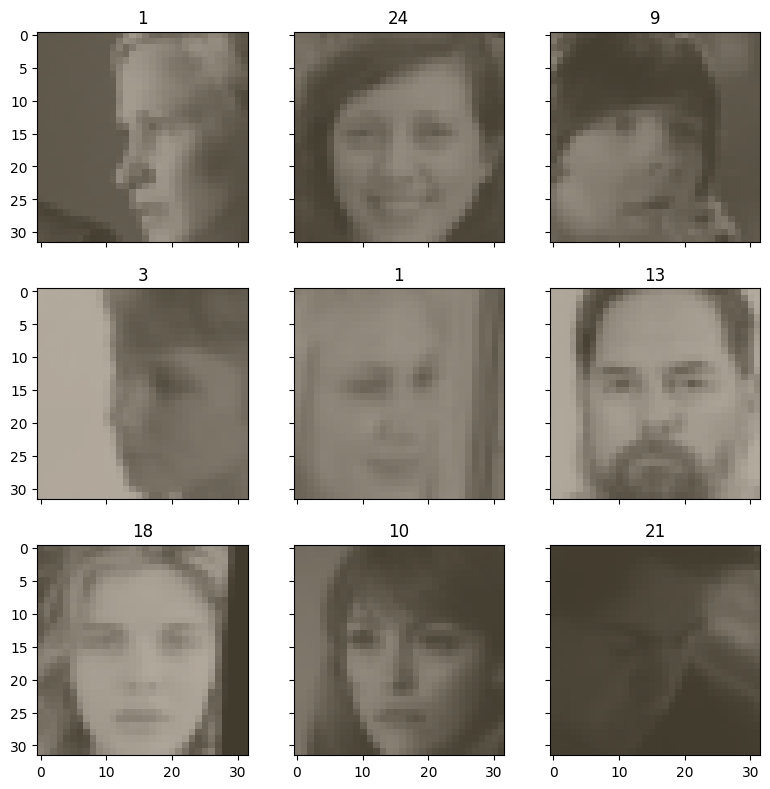

In [9]:
transf = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset1 = datasets.ImageFolder(TRAIN_PATH, transf)
dataset2 = datasets.ImageFolder(VAL_PATH, transf)
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
fig.tight_layout()
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = dataset1[random_characters]
    # print(im_val.shape)
    imshow(im_val.data.cpu(), \
          title=label,plt_ax=fig_x)

Подготовим датасеты и dataloader'ы для дальнейшего обучения и валидации.

In [10]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_train = datasets.ImageFolder(TRAIN_PATH, train_transform)

In [11]:
#dataloader for subset dataset for faster train
evens = list(range(0, len(dataset_train), 20))
dataset_train_1 = torch.utils.data.Subset(dataset_train, evens)
train_loader_1 = torch.utils.data.DataLoader(dataset_train_1, batch_size=TRAIN_BATCH_SIZE, drop_last=True)
num_class=10572

In [12]:
# uncomment it for finall train
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=TRAIN_BATCH_SIZE, drop_last=True)
num_class = len(train_loader.dataset.classes)
print('Number of Training Classes: %d' % num_class)

Number of Training Classes: 10572


In [13]:
path_list, issame_list = get_paths(VAL_PATH, FILE_EXT)
issame_list = [0] * 3000 + [1] * 3000
val_loader = torch.utils.data.DataLoader(LFWDataset(path_list, issame_list, val_transform), batch_size=VAL_BATCH_SIZE, shuffle=False)

Подготовим модель на базе предобученных моделей.

In [14]:
if MODEL_NAME.lower()=='resnet34':
    backbone = torchvision.models.resnet34(pretrained=True)
elif MODEL_NAME.lower()=='inceptionresnetv1':
    backbone = InceptionResnetV1(pretrained='vggface2')
else:
    backbone = InceptionResnetV1(pretrained='vggface2')

In [15]:
# model = Net(backbone, num_class, ALPHA_1, FEAT_DIM)
model = MobNet(num_class, FEAT_DIM)
print(MODEL_NAME) # check it

MobNet


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ', device)
model.to(device)

Device:  cuda:0


MobNet(
  (conv_bn_0): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0, inplace=True)
  )
  (stage1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negativ

Для классификации используем Softmax loss, в случае добавления пересчетов центров для каждого пользователя, добавим CenterLoss.
Для простоты будем использовать Adam в качестве оптимайзера.

In [17]:
criterion_softmax = nn.CrossEntropyLoss()
criterion_softmax = criterion_softmax.to(device)
optimizer_softmax = optim.Adam(model.parameters(), lr=LR_SOFTMAX, weight_decay=WEIGHT_DECAY)
# Center loss
if FLAG_CENTER:
    criterion_centerloss = CenterLoss(num_classes=num_class, feat_dim=FEAT_DIM, use_gpu=True)
    optimizer_center = optim.Adam(criterion_centerloss.parameters(), lr=LR_CENTER)
else:
    pass

Обучение и валидация происходят на каждой эпохе, сохраняем checkpoint'ы в models, графики roc_auc в plots.

In [18]:
train_loader = train_loader_1

Epoch 0/4
Epoch 0/4 Batch 0/94
Train Batch Loss: 9.3412 Acc: 0.0000
Epoch 0/4 Batch 1/94
Train Batch Loss: 9.3769 Acc: 0.0000
Epoch 0/4 Batch 2/94
Train Batch Loss: 9.3436 Acc: 0.0000
Epoch 0/4 Batch 3/94
Train Batch Loss: 9.3329 Acc: 0.0000
Epoch 0/4 Batch 4/94
Train Batch Loss: 9.3567 Acc: 0.0000
Epoch 0/4 Batch 5/94
Train Batch Loss: 9.3649 Acc: 0.0000
Epoch 0/4 Batch 6/94
Train Batch Loss: 9.3982 Acc: 0.0000
Epoch 0/4 Batch 7/94
Train Batch Loss: 9.2691 Acc: 0.0000
Epoch 0/4 Batch 8/94
Train Batch Loss: 9.2917 Acc: 0.0000
Epoch 0/4 Batch 9/94
Train Batch Loss: 9.3480 Acc: 0.0000
Epoch 0/4 Batch 10/94
Train Batch Loss: 9.3085 Acc: 0.0000
Epoch 0/4 Batch 11/94
Train Batch Loss: 9.3324 Acc: 0.0000
Epoch 0/4 Batch 12/94
Train Batch Loss: 9.3650 Acc: 0.0000
Epoch 0/4 Batch 13/94
Train Batch Loss: 9.3537 Acc: 0.0000
Epoch 0/4 Batch 14/94
Train Batch Loss: 9.3556 Acc: 0.0000
Epoch 0/4 Batch 15/94
Train Batch Loss: 9.3655 Acc: 0.0000
Epoch 0/4 Batch 16/94
Train Batch Loss: 9.3925 Acc: 0.00

Extracting features: 100%|██████████| 12000/12000 [01:05<00:00, 183.23it/s]


ROC-AUC: 0.5196
LFW VAL AUC: 0.5196, LFW VAL EER: 0.4900
Current Best val ROC AUC: 0.519639
Epoch 1/4
Epoch 1/4 Batch 0/94
Train Batch Loss: 8.3936 Acc: 0.0117
Epoch 1/4 Batch 1/94
Train Batch Loss: 8.4950 Acc: 0.0039
Epoch 1/4 Batch 2/94
Train Batch Loss: 8.5641 Acc: 0.0039
Epoch 1/4 Batch 3/94
Train Batch Loss: 8.5392 Acc: 0.0078
Epoch 1/4 Batch 4/94
Train Batch Loss: 8.5165 Acc: 0.0078
Epoch 1/4 Batch 5/94
Train Batch Loss: 8.5109 Acc: 0.0156
Epoch 1/4 Batch 6/94
Train Batch Loss: 8.5824 Acc: 0.0039
Epoch 1/4 Batch 7/94
Train Batch Loss: 8.4058 Acc: 0.0312
Epoch 1/4 Batch 8/94
Train Batch Loss: 8.4755 Acc: 0.0000
Epoch 1/4 Batch 9/94
Train Batch Loss: 8.5488 Acc: 0.0039
Epoch 1/4 Batch 10/94
Train Batch Loss: 8.4998 Acc: 0.0078
Epoch 1/4 Batch 11/94
Train Batch Loss: 8.5277 Acc: 0.0039
Epoch 1/4 Batch 12/94
Train Batch Loss: 8.5914 Acc: 0.0000
Epoch 1/4 Batch 13/94
Train Batch Loss: 8.5751 Acc: 0.0039
Epoch 1/4 Batch 14/94
Train Batch Loss: 8.5773 Acc: 0.0039
Epoch 1/4 Batch 15/94
T

Extracting features: 100%|██████████| 12000/12000 [01:01<00:00, 196.23it/s]


ROC-AUC: 0.5130
LFW VAL AUC: 0.5130, LFW VAL EER: 0.4917
Current Best val ROC AUC: 0.519639
Epoch 2/4
Epoch 2/4 Batch 0/94
Train Batch Loss: 8.0480 Acc: 0.0273
Epoch 2/4 Batch 1/94
Train Batch Loss: 8.1276 Acc: 0.0039
Epoch 2/4 Batch 2/94
Train Batch Loss: 8.2163 Acc: 0.0039
Epoch 2/4 Batch 3/94
Train Batch Loss: 8.1301 Acc: 0.0234
Epoch 2/4 Batch 4/94
Train Batch Loss: 8.1447 Acc: 0.0156
Epoch 2/4 Batch 5/94
Train Batch Loss: 8.1100 Acc: 0.0195
Epoch 2/4 Batch 6/94
Train Batch Loss: 8.1741 Acc: 0.0078
Epoch 2/4 Batch 7/94
Train Batch Loss: 8.0127 Acc: 0.0469
Epoch 2/4 Batch 8/94
Train Batch Loss: 8.0627 Acc: 0.0117
Epoch 2/4 Batch 9/94
Train Batch Loss: 8.1672 Acc: 0.0039
Epoch 2/4 Batch 10/94
Train Batch Loss: 8.1322 Acc: 0.0039
Epoch 2/4 Batch 11/94
Train Batch Loss: 8.1578 Acc: 0.0078
Epoch 2/4 Batch 12/94
Train Batch Loss: 8.1963 Acc: 0.0039
Epoch 2/4 Batch 13/94
Train Batch Loss: 8.1859 Acc: 0.0039
Epoch 2/4 Batch 14/94
Train Batch Loss: 8.1934 Acc: 0.0000
Epoch 2/4 Batch 15/94
T

Extracting features: 100%|██████████| 12000/12000 [01:00<00:00, 196.86it/s]


ROC-AUC: 0.5132
LFW VAL AUC: 0.5132, LFW VAL EER: 0.4943
Current Best val ROC AUC: 0.519639
Epoch 3/4
Epoch 3/4 Batch 0/94
Train Batch Loss: 7.7811 Acc: 0.0430
Epoch 3/4 Batch 1/94
Train Batch Loss: 7.8397 Acc: 0.0156
Epoch 3/4 Batch 2/94
Train Batch Loss: 7.9418 Acc: 0.0234
Epoch 3/4 Batch 3/94
Train Batch Loss: 7.8347 Acc: 0.0312
Epoch 3/4 Batch 4/94
Train Batch Loss: 7.8560 Acc: 0.0195
Epoch 3/4 Batch 5/94
Train Batch Loss: 7.8064 Acc: 0.0273
Epoch 3/4 Batch 6/94
Train Batch Loss: 7.8853 Acc: 0.0195
Epoch 3/4 Batch 7/94
Train Batch Loss: 7.7151 Acc: 0.0508
Epoch 3/4 Batch 8/94
Train Batch Loss: 7.7478 Acc: 0.0312
Epoch 3/4 Batch 9/94
Train Batch Loss: 7.8612 Acc: 0.0078
Epoch 3/4 Batch 10/94
Train Batch Loss: 7.8415 Acc: 0.0195
Epoch 3/4 Batch 11/94
Train Batch Loss: 7.8729 Acc: 0.0078
Epoch 3/4 Batch 12/94
Train Batch Loss: 7.8872 Acc: 0.0078
Epoch 3/4 Batch 13/94
Train Batch Loss: 7.8855 Acc: 0.0117
Epoch 3/4 Batch 14/94
Train Batch Loss: 7.8964 Acc: 0.0078
Epoch 3/4 Batch 15/94
T

Extracting features: 100%|██████████| 12000/12000 [01:00<00:00, 197.37it/s]


ROC-AUC: 0.5143
LFW VAL AUC: 0.5143, LFW VAL EER: 0.4873
Current Best val ROC AUC: 0.519639
Epoch 4/4
Epoch 4/4 Batch 0/94
Train Batch Loss: 7.5529 Acc: 0.0625
Epoch 4/4 Batch 1/94
Train Batch Loss: 7.6347 Acc: 0.0273
Epoch 4/4 Batch 2/94
Train Batch Loss: 7.7721 Acc: 0.0234
Epoch 4/4 Batch 3/94
Train Batch Loss: 7.6395 Acc: 0.0391
Epoch 4/4 Batch 4/94
Train Batch Loss: 7.6702 Acc: 0.0234
Epoch 4/4 Batch 5/94
Train Batch Loss: 7.5932 Acc: 0.0352
Epoch 4/4 Batch 6/94
Train Batch Loss: 7.6795 Acc: 0.0234
Epoch 4/4 Batch 7/94
Train Batch Loss: 7.4692 Acc: 0.0664
Epoch 4/4 Batch 8/94
Train Batch Loss: 7.5023 Acc: 0.0586
Epoch 4/4 Batch 9/94
Train Batch Loss: 7.6295 Acc: 0.0195
Epoch 4/4 Batch 10/94
Train Batch Loss: 7.6428 Acc: 0.0156
Epoch 4/4 Batch 11/94
Train Batch Loss: 7.6665 Acc: 0.0234
Epoch 4/4 Batch 12/94
Train Batch Loss: 7.6858 Acc: 0.0117
Epoch 4/4 Batch 13/94
Train Batch Loss: 7.6721 Acc: 0.0117
Epoch 4/4 Batch 14/94
Train Batch Loss: 7.6723 Acc: 0.0000
Epoch 4/4 Batch 15/94
T

Extracting features: 100%|██████████| 12000/12000 [01:00<00:00, 197.66it/s]


ROC-AUC: 0.5064
LFW VAL AUC: 0.5064, LFW VAL EER: 0.4977
Current Best val ROC AUC: 0.519639
Training complete


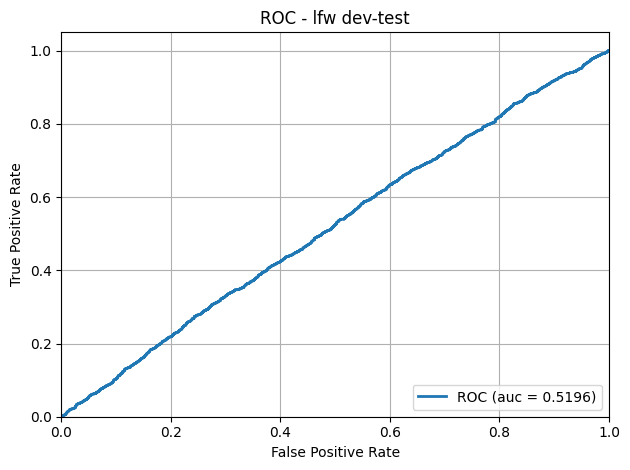

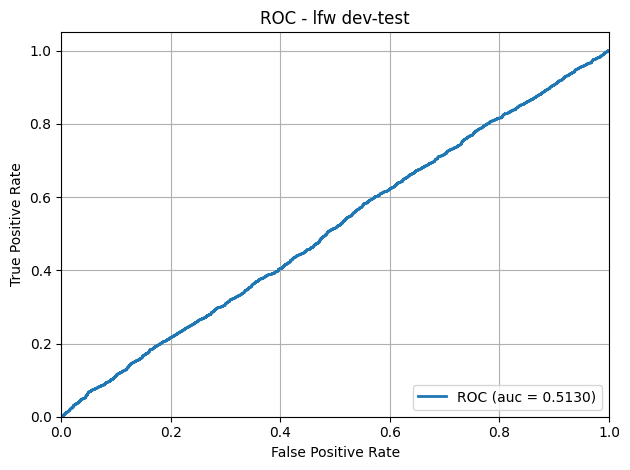

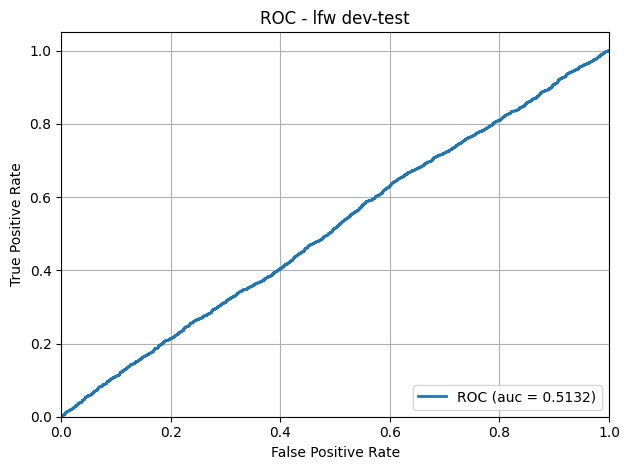

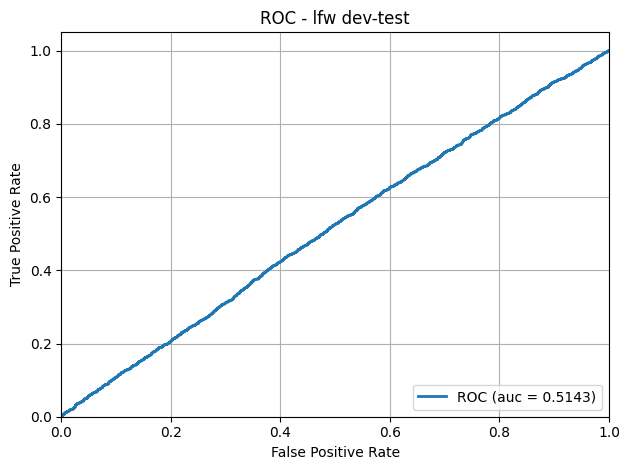

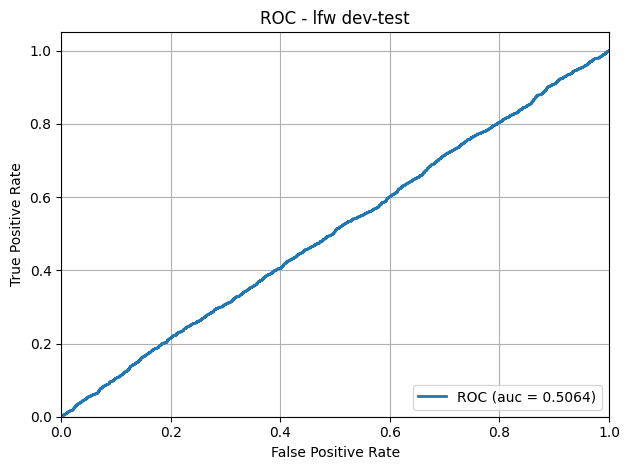

In [19]:
train(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model,
    optimizer=optimizer_softmax,
    criterion=criterion_softmax,
    issame_list=issame_list,
    device=device,
    scheduler=True,
    num_epochs=5,
    fig_path=cfg['PLOT_PATH'],
    logs_save=cfg['LOGS_PATH'],
    checkpoint_save=cfg['CHECKPOINT'],
    model_name=MODEL_NAME+'test3',
)

Extracting features: 100%|██████████| 12000/12000 [01:00<00:00, 197.26it/s]


ROC-AUC: 0.5196


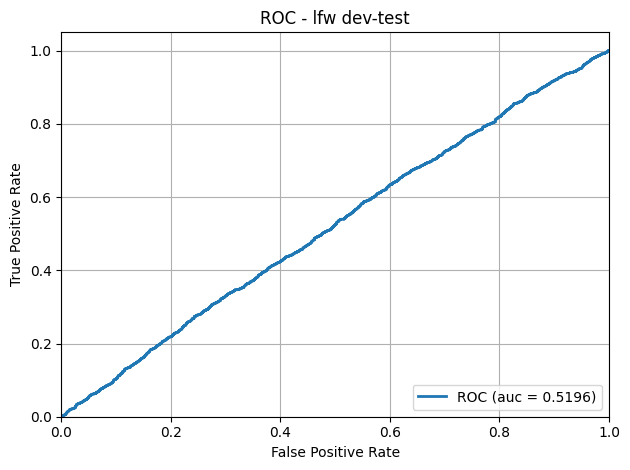

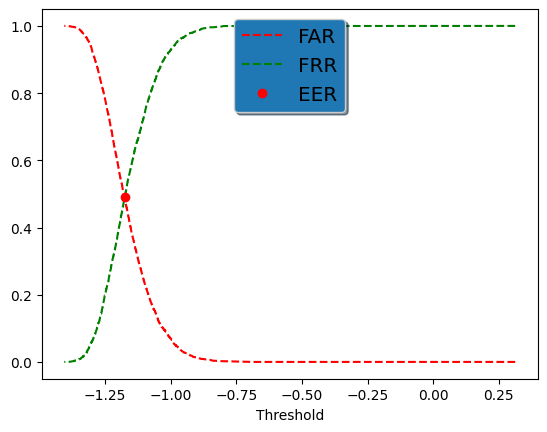

LFW VAL AUC: 0.5196, LFW VAL EER: 0.4900


In [21]:
evaluate(
    model=model.to(device),
    optimizer=optimizer_softmax,
    checkpoint_path='/content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition/models/MobNettest3_CASIA-WEB-FACE-Aligned_Epoch_0_LfwAUC_0.5196385555555556.tar',
    device=device,
    val_loader=val_loader,
    issame_list=issame_list
)

Да, результаты, конечно, удручающие, но это потому, что мы смотрим точность только после первой эпохи. Сеть еще не успела достаточно обучиться. (мы помним, что классов у нас 10572) Надо бы обучить хотя бы на 90 эпохах, но на данный момент, у меня пока нет сервера, на котором я бы смогла это сделать за приемлемое время.

 Далее рассмотрены сети, которые используют предобученные ResNet и InceptionResNet, в качестве backbon'а. Но так как эти сети изначально обучались на RGB иображениях, с позиции логики, будет неверным подавать черно-белые фото на вход. Можно, конечно, добавить один слой перед backbon'ом, который преобразует входное изображение в 3х канальное, но скорее всего полученный тензор будет иметь мало общего с исходной картинкой и картинкой в принципе, что приведет к бесполезности использования Transfer Learning подхода.

Поэтому подготовим отдельно новые train и val dataloader'ы, которые будут содержать 3х канальные изображения.

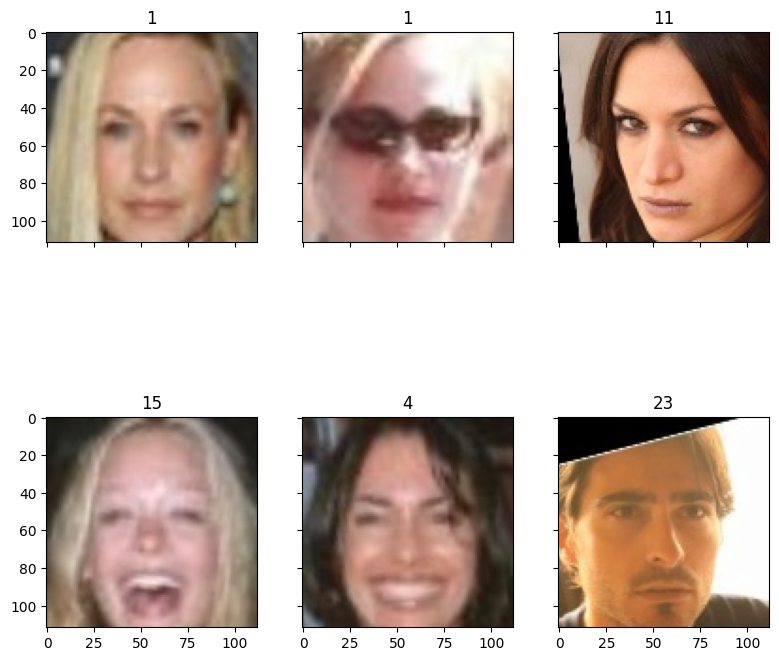

In [22]:
transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=RGB_MEAN,
                         std=RGB_STD),
])
dataset_casia = datasets.ImageFolder(TRAIN_PATH, transf)
dataset_lfw = datasets.ImageFolder(VAL_PATH, transf)
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
fig.tight_layout()
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = dataset_casia[random_characters]
    imshow(im_val.data.cpu(), \
          title=label,plt_ax=fig_x)

In [23]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=RGB_MEAN,std=RGB_STD),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=RGB_MEAN,
                         std=RGB_STD),
])

dataset_train = datasets.ImageFolder(TRAIN_PATH, train_transform)

In [27]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=TRAIN_BATCH_SIZE, drop_last=True)
num_class = len(train_loader.dataset.classes)
print('Number of Training Classes: %d' % num_class)
path_list, issame_list = get_paths(VAL_PATH, FILE_EXT)
issame_list = [0] * 3000 + [1] * 3000
val_loader = torch.utils.data.DataLoader(LFWDataset(path_list, issame_list, val_transform), batch_size=VAL_BATCH_SIZE, shuffle=False)

Number of Training Classes: 10572


In [28]:
#dataloader for subset dataset for faster train
evens = list(range(0, len(dataset_train), 30))
dataset_train_1 = torch.utils.data.Subset(dataset_train, evens)
train_loader_1 = torch.utils.data.DataLoader(dataset_train_1, batch_size=TRAIN_BATCH_SIZE, drop_last=True)
num_class=10572

Epoch 0/0
Epoch 0/0 Batch 0/62
Train Batch Loss: 9.2670 Acc: 0.0000
Epoch 0/0 Batch 1/62
Train Batch Loss: 9.2638 Acc: 0.0000
Epoch 0/0 Batch 2/62
Train Batch Loss: 9.2689 Acc: 0.0000
Epoch 0/0 Batch 3/62
Train Batch Loss: 9.2649 Acc: 0.0000
Epoch 0/0 Batch 4/62
Train Batch Loss: 9.2664 Acc: 0.0000
Epoch 0/0 Batch 5/62
Train Batch Loss: 9.2727 Acc: 0.0000
Epoch 0/0 Batch 6/62
Train Batch Loss: 9.2659 Acc: 0.0000
Epoch 0/0 Batch 7/62
Train Batch Loss: 9.2705 Acc: 0.0000
Epoch 0/0 Batch 8/62
Train Batch Loss: 9.2741 Acc: 0.0000
Epoch 0/0 Batch 9/62
Train Batch Loss: 9.2623 Acc: 0.0000
Epoch 0/0 Batch 10/62
Train Batch Loss: 9.2768 Acc: 0.0000
Epoch 0/0 Batch 11/62
Train Batch Loss: 9.2597 Acc: 0.0000
Epoch 0/0 Batch 12/62
Train Batch Loss: 9.2610 Acc: 0.0000
Epoch 0/0 Batch 13/62
Train Batch Loss: 9.2639 Acc: 0.0000
Epoch 0/0 Batch 14/62
Train Batch Loss: 9.2709 Acc: 0.0000
Epoch 0/0 Batch 15/62
Train Batch Loss: 9.2623 Acc: 0.0039
Epoch 0/0 Batch 16/62
Train Batch Loss: 9.2633 Acc: 0.00

Extracting features: 100%|██████████| 12000/12000 [05:26<00:00, 36.81it/s]


ROC-AUC: 0.9951
LFW VAL AUC: 0.9951, LFW VAL EER: 0.0340
Current Best val ROC AUC: 0.995138
Training complete


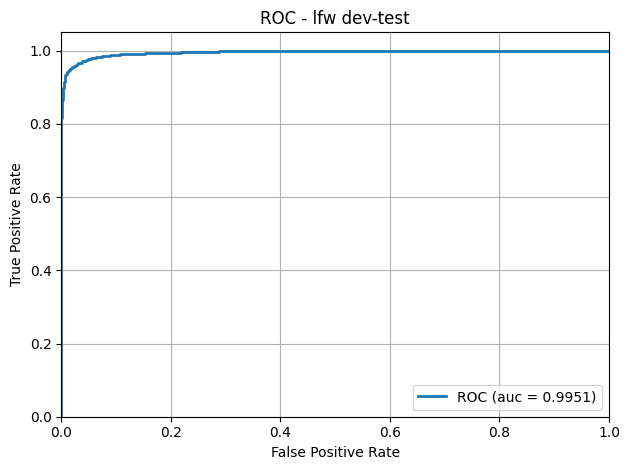

In [31]:
MODEL_NAME = 'SimpleNet'
model_incept = SimpleNet(backbone, num_class).to(device)
train(
    train_loader=train_loader_1,
    val_loader=val_loader,
    model=model_incept,
    optimizer=optimizer_softmax,
    criterion=criterion_softmax,
    issame_list=issame_list,
    device=device,
    scheduler=True,
    num_epochs=1,
    fig_path=cfg['PLOT_PATH'],
    logs_save=cfg['LOGS_PATH'],
    checkpoint_save=cfg['CHECKPOINT'],
    model_name=MODEL_NAME+'test4',
)

Extracting features: 100%|██████████| 12000/12000 [05:18<00:00, 37.65it/s]


ROC-AUC: 0.9951


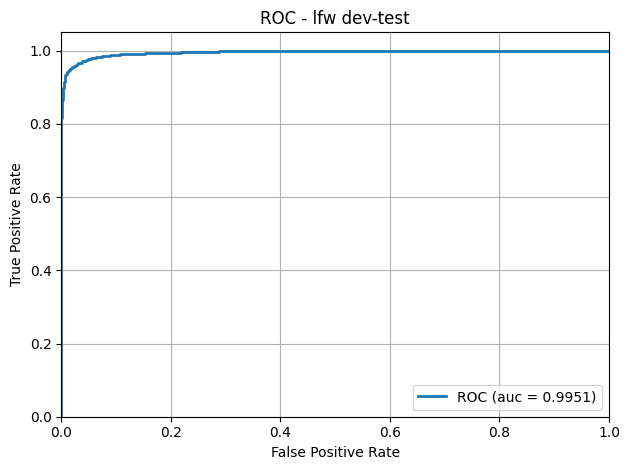

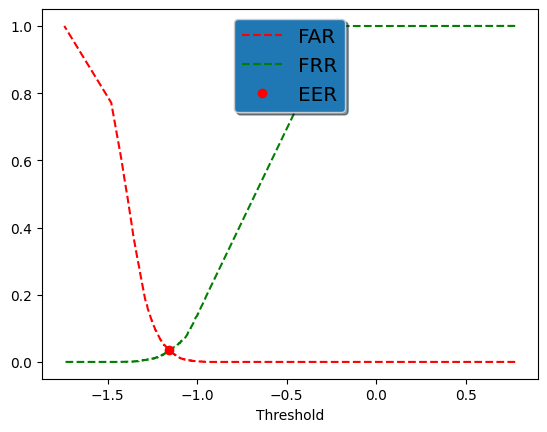

LFW VAL AUC: 0.9951, LFW VAL EER: 0.0340


In [32]:
MODEL_NAME = 'SimpleNet'
model_incept = SimpleNet(backbone, num_class).to(device)
# optimizer_softmax =
evaluate(
    model=model_incept.to(device),
    optimizer=optimizer_softmax,
    checkpoint_path='/content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition/models/SimpleNettest4_CASIA-WEB-FACE-Aligned_Epoch_0_LfwAUC_0.9951378888888889.tar',
    device=device,
    val_loader=val_loader,
    issame_list=issame_list
)

Нужно заметить, что мы используем backbone InceptionResnetV1, который предобучен на VGGFace2, поэтому при верификации он дает хорошие результаты. 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 220MB/s]


Epoch 0/0
Epoch 0/0 Batch 0/62
Train Batch Loss: 9.2630 Acc: 0.0000
Epoch 0/0 Batch 1/62
Train Batch Loss: 9.2612 Acc: 0.0000
Epoch 0/0 Batch 2/62
Train Batch Loss: 9.2631 Acc: 0.0039
Epoch 0/0 Batch 3/62
Train Batch Loss: 9.2769 Acc: 0.0000
Epoch 0/0 Batch 4/62
Train Batch Loss: 9.2525 Acc: 0.0000
Epoch 0/0 Batch 5/62
Train Batch Loss: 9.2515 Acc: 0.0000
Epoch 0/0 Batch 6/62
Train Batch Loss: 9.2761 Acc: 0.0000
Epoch 0/0 Batch 7/62
Train Batch Loss: 9.2748 Acc: 0.0000
Epoch 0/0 Batch 8/62
Train Batch Loss: 9.2812 Acc: 0.0000
Epoch 0/0 Batch 9/62
Train Batch Loss: 9.2812 Acc: 0.0039
Epoch 0/0 Batch 10/62
Train Batch Loss: 9.2690 Acc: 0.0000
Epoch 0/0 Batch 11/62
Train Batch Loss: 9.2867 Acc: 0.0000
Epoch 0/0 Batch 12/62
Train Batch Loss: 9.2966 Acc: 0.0000
Epoch 0/0 Batch 13/62
Train Batch Loss: 9.2807 Acc: 0.0000
Epoch 0/0 Batch 14/62
Train Batch Loss: 9.2758 Acc: 0.0000
Epoch 0/0 Batch 15/62
Train Batch Loss: 9.2833 Acc: 0.0039
Epoch 0/0 Batch 16/62
Train Batch Loss: 9.2702 Acc: 0.00

Extracting features: 100%|██████████| 12000/12000 [01:51<00:00, 107.87it/s]


ROC-AUC: 0.7189
LFW VAL AUC: 0.7189, LFW VAL EER: 0.3407
Current Best val ROC AUC: 0.718880
Training complete


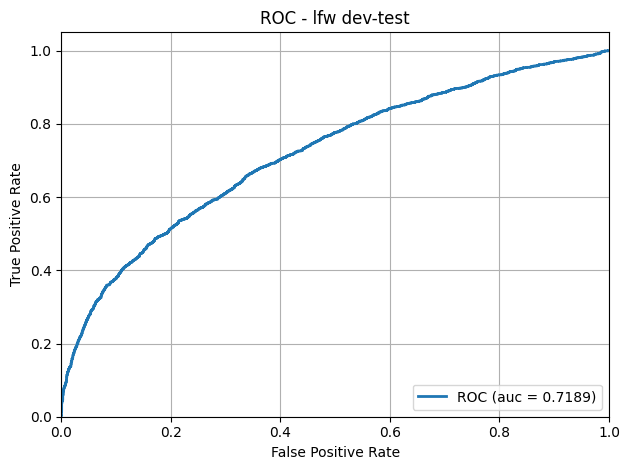

In [33]:
backbone = torchvision.models.resnet34(pretrained=True)
model_net = Net(backbone, num_class, ALPHA_1, FEAT_DIM).to(device)
criterion_softmax = nn.CrossEntropyLoss()
criterion_softmax = criterion_softmax.to(device)
optimizer_softmax = optim.SGD(model.parameters(), lr=LR_SOFTMAX, weight_decay=WEIGHT_DECAY)
MODEL_NAME = 'Net'
train(
    train_loader=train_loader_1,
    val_loader=val_loader,
    model=model_net,
    optimizer=optimizer_softmax,
    criterion=criterion_softmax,
    issame_list=issame_list,
    device=device,
    scheduler=True,
    num_epochs=1,
    fig_path=cfg['PLOT_PATH'],
    logs_save=cfg['LOGS_PATH'],
    checkpoint_save=cfg['CHECKPOINT'],
    model_name=MODEL_NAME+'test3',
)

Extracting features: 100%|██████████| 12000/12000 [01:50<00:00, 108.44it/s]


ROC-AUC: 0.7189


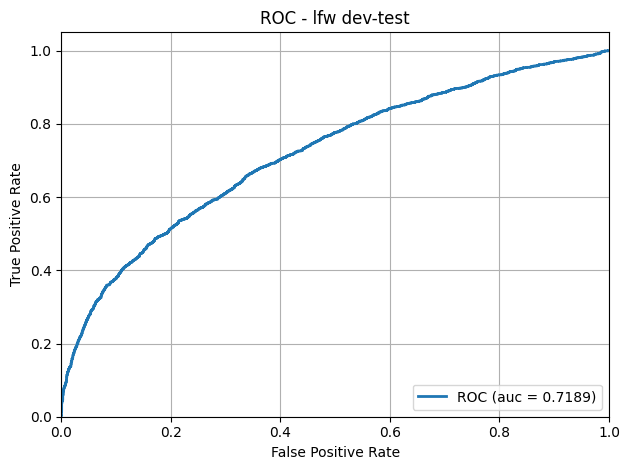

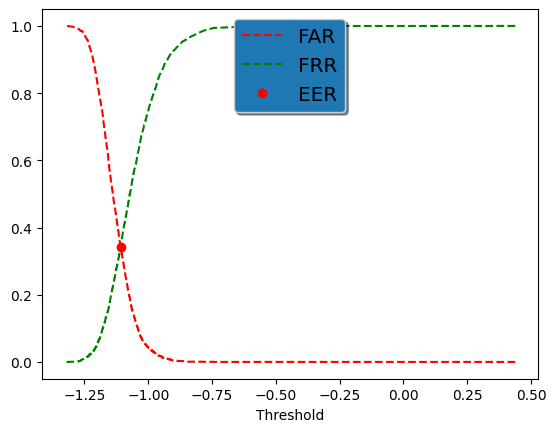

LFW VAL AUC: 0.7189, LFW VAL EER: 0.3407


In [34]:
evaluate(
    model=model_net.to(device),
    optimizer=optimizer_softmax,
    checkpoint_path='/content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition/models/Nettest3_CASIA-WEB-FACE-Aligned_Epoch_0_LfwAUC_0.7188801111111112.tar',
    device=device,
    val_loader=val_loader,
    issame_list=issame_list
)

Тут мы тоже использовали хорошую сеть в качетсве backbon'а. 
Далее показан запуск с ипользованием дополнительного лосса для оптимизации центров для каждого пользователя. Так же используется ResNet34 в качестве backbona модели. 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/0
Epoch 0/0 Batch 0/62


/content/gdrive/MyDrive/Samal_experiments/DL/FaceRecognition/utils.py:59: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  distmat.addmm_(1, -2, x, self.centers.t())


Train Batch Loss: 21.5558 Train Batch Softmax Loss: 9.2712 Train Batch Center Loss: 12.2846 Acc: 0.0000
Epoch 0/0 Batch 1/62
Train Batch Loss: 21.4456 Train Batch Softmax Loss: 9.2800 Train Batch Center Loss: 12.1657 Acc: 0.0000
Epoch 0/0 Batch 2/62
Train Batch Loss: 21.4793 Train Batch Softmax Loss: 9.2779 Train Batch Center Loss: 12.2014 Acc: 0.0000
Epoch 0/0 Batch 3/62
Train Batch Loss: 21.6333 Train Batch Softmax Loss: 9.2659 Train Batch Center Loss: 12.3673 Acc: 0.0000
Epoch 0/0 Batch 4/62
Train Batch Loss: 21.3078 Train Batch Softmax Loss: 9.2727 Train Batch Center Loss: 12.0351 Acc: 0.0000
Epoch 0/0 Batch 5/62
Train Batch Loss: 21.4457 Train Batch Softmax Loss: 9.2921 Train Batch Center Loss: 12.1535 Acc: 0.0000
Epoch 0/0 Batch 6/62
Train Batch Loss: 21.5224 Train Batch Softmax Loss: 9.2764 Train Batch Center Loss: 12.2460 Acc: 0.0000
Epoch 0/0 Batch 7/62
Train Batch Loss: 21.6330 Train Batch Softmax Loss: 9.2683 Train Batch Center Loss: 12.3647 Acc: 0.0000
Epoch 0/0 Batch 8/62


Extracting features: 100%|██████████| 12000/12000 [01:49<00:00, 109.31it/s]


ROC-AUC: 0.7150
LFW VAL AUC: 0.7150, LFW VAL EER: 0.3453
Current Best val ROC AUC: 0.714963
Training complete


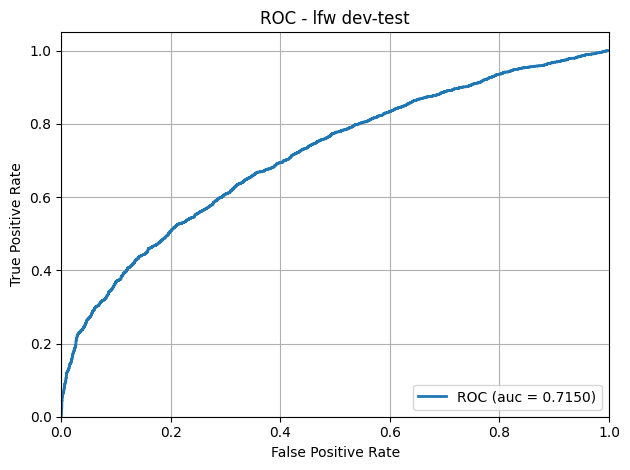

In [35]:
backbone = torchvision.models.resnet34(pretrained=True)
model_net_center = Net(backbone, num_class, ALPHA_1, FEAT_DIM).to(device)
criterion_softmax = nn.CrossEntropyLoss()
criterion_softmax = criterion_softmax.to(device)
criterion_centerloss = CenterLoss(num_classes=num_class, feat_dim=FEAT_DIM, use_gpu=True)
optimizer_center = optim.Adam(criterion_centerloss.parameters(), lr=LR_CENTER)
optimizer_softmax = optim.Adam(model.parameters(), lr=LR_SOFTMAX, weight_decay=WEIGHT_DECAY)
MODEL_NAME = 'Net'
train(
    train_loader=train_loader_1,
    val_loader=val_loader,
    model=model_net_center,
    optimizer=optimizer_softmax,
    criterion=criterion_softmax,
    issame_list=issame_list,
    device=device,
    scheduler=True,
    num_epochs=1,
    fig_path=cfg['PLOT_PATH'],
    logs_save=cfg['LOGS_PATH'],
    checkpoint_save=cfg['CHECKPOINT'],
    model_name=MODEL_NAME+'testCenter',
    flag_center=True,
    criterion_centerloss=criterion_centerloss,
    optimizer_center=optimizer_center,
    alpha=ALPHA
)